In [1]:
import pandas as pd
import seaborn
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import OptimizeWarning
import warnings

import decomposition
import potential_data
import scaler
import plots
import potential_analyze
import fit
import functional

pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore", OptimizeWarning)

      r/a     aV(r)       err
beta                         
6.0     1  0.052158  0.000003
6.0     2  0.116603  0.000012
6.0     3  0.206447  0.000038
6.0     4  0.275846  0.000093
6.0     5  0.336712  0.000235
...   ...       ...       ...
6.4    16  0.391857  0.001407
6.4    17  0.407409  0.001709
6.4    18  0.423064  0.001940
6.4    19  0.438591  0.002120
6.4    20  0.454069  0.002361

[80 rows x 3 columns]
            V0    V0_err     alpha  alpha_err     sigma  sigma_err  \
beta                                                                 
6.0  -0.084142  0.000131  0.047432   0.000092  0.088859   0.000040   
6.0  -0.083000  0.000130  0.046649   0.000091  0.088501   0.000040   
6.0  -0.081768  0.000129  0.045802   0.000091  0.088114   0.000039   
6.0  -0.080682  0.000128  0.045056   0.000090  0.087774   0.000039   
6.0  -0.079784  0.000128  0.044438   0.000090  0.087493   0.000039   
...        ...       ...       ...        ...       ...        ...   
6.4   0.171715  0.025999 -0

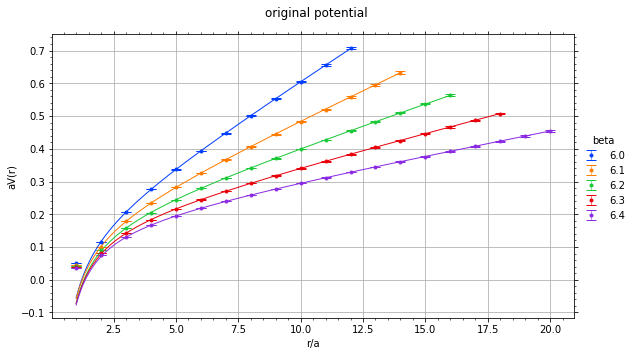

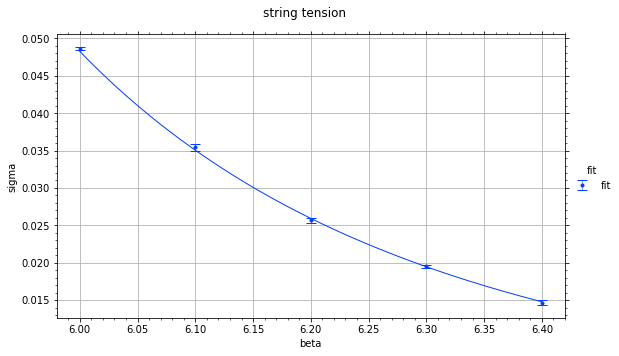

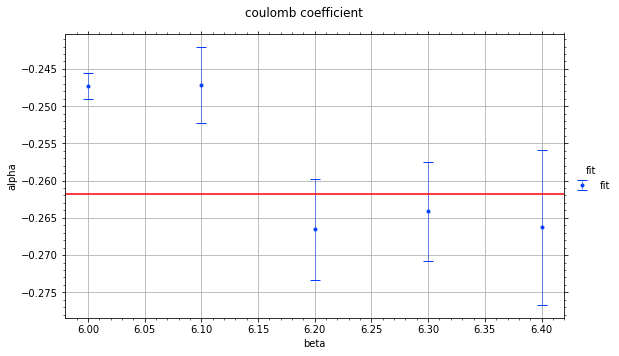

In [2]:
show_plot = True
coordinate = 'r/a'
hue = 'beta'
groupby = []
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (1, 11)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/28^4/beta6.1/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.1}, 'constraints': {'r/a': (1, 14), 'T': (1, 13)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.2}, 'constraints': {'r/a': (1, 16), 'T': (1, 16)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.3}, 'constraints': {'r/a': (1, 18), 'T': (1, 18)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/40^4/beta6.4/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.4}, 'constraints': {'r/a': (1, 20), 'T': (1, 20)}}]
image_path = f'../../images/potential/su3/gluodynamics/'
image_name = f'beta_comparison'
df = potential_data.get_potantial_df(paths)
df = df.groupby(df.index.names + ['r/a']).apply(fit.potential_fit_T_range, 9).reset_index(level=['r/a']).reset_index(level=-1, drop=True)
df = df.drop('T', axis = 1)
print(df)
df_fit = df.groupby(df.index.names).apply(fit.make_fit_range, fit.func_cornell, 8, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err').reset_index(level=-1, drop=True)
print(df_fit)
df_fit = df_fit.groupby(df.index.names).apply(fit.average_fit_p_value, ['V0', 'alpha', 'sigma'], 'r/a').reset_index(level=-1, drop=True)
print(df_fit)
df_curves = df_fit.groupby(df_fit.index.names).apply(fit.make_fit_curve, fit.func_cornell, 'r/a', 'aV(r)', ['V0', 'alpha', 'sigma']).reset_index(level=-1, drop=True)
print(df_curves)
df = df.reset_index(level='beta')
df_curves = df_curves.reset_index(level='beta')
plots.plot_potential_single(df, coordinate, 'aV(r)', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, err='err', df_fits=df_curves)
x_fit = np.linspace(6, 6.4, 1000)
y_fit = scaler.get_a_sqrt_sigma(x_fit) ** 2
df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
df_string_tension_fit['fit'] = 'fit'
df_fit['fit'] = 'fit'
df_fit = df_fit.reset_index(level='beta')
plots.plot_potential_single(df_fit, 'beta', 'sigma', 'fit', 'beta', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/', 'string_tension', show_plot, err='sigma_err', df_fits=df_string_tension_fit)
plots.plot_potential_single(df_fit, 'beta', 'alpha', 'fit', 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/gluodynamics/', 'coulomb_coefficient', show_plot, err='alpha_err', black_line_y=-math.pi/12)

In [4]:
# fit linear string tension for each copy and plot string tension
# dependence on average functional of gauge copy
def string_tension_copy(paths_potential, paths_functional, image_path_potential, image_name_potential, image_path_functional, image_name_functional):
    data = potential_data.get_potantial_df(paths_potential)
    data = data.drop('T', axis = 1)
    # df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (5, 12), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
    #                 .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
    fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
    fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
    fit_params['sigma'] = np.sqrt(fit_params['sigma'])
    df_func = functional.read_functional(paths_functional)
    df_func = functional.fill_funcational_max(df_func, ['steps'])
    fit_params = fit_params.merge(df_func, how='inner', on=['steps', 'copy'])
    plots.plot_potential_single(data, 'r/a', 'aV(r)', 'err', 'copy', 'r/a', 'aV(r)', 'original potential', image_path_potential, image_name_potential, True)
    plots.plot_potential_single(fit_params, 'functional', 'sigma', 'sigma_err', None, 'functional', 'sigma', 'string tension', image_path_functional, image_name_functional, True)

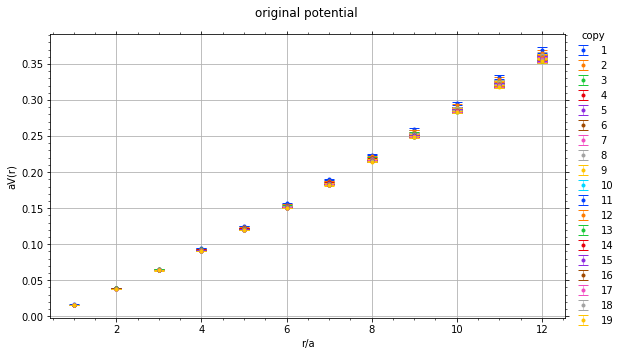

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//copy_comparison


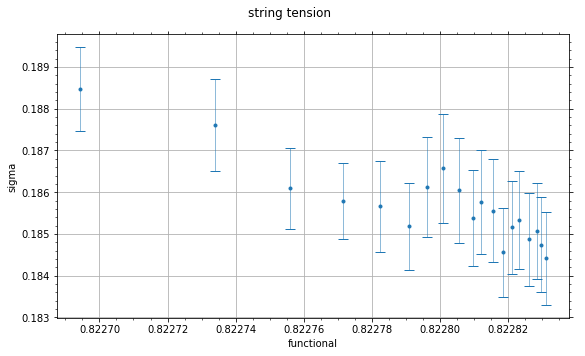

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//string_tension_functional


In [11]:
paths_potential = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_100/copies=20/0.01/potential_monopole.csv',
          'parameters': {'beta': 6.0, 'steps': 100}, 'constraints': {'r/a': (1, 12), 'T': (10, 10)}}]
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 100}}]
image_path_potential = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/'
image_name_potential = f'copy_comparison'
image_path_functional = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/'
image_name_functional = 'string_tension_functional'
string_tension_copy(paths_potential, paths_functional, image_path_potential, image_name_potential, image_path_functional, image_name_functional)

    copy  beta        V0    V0_err     alpha  alpha_err     sigma  sigma_err  \
0      1   6.0 -0.070758  0.003500  0.090771   0.007413  0.035521   0.000379   
1      2   6.0 -0.070871  0.003784  0.091756   0.007994  0.035199   0.000411   
2      3   6.0 -0.067968  0.003304  0.086816   0.006985  0.034631   0.000359   
3      4   6.0 -0.067580  0.003130  0.086094   0.006612  0.034517   0.000340   
4      5   6.0 -0.068512  0.003728  0.088493   0.007866  0.034472   0.000406   
5      6   6.0 -0.067812  0.003548  0.087488   0.007510  0.034294   0.000385   
6      7   6.0 -0.070443  0.004122  0.092175   0.008712  0.034641   0.000448   
7      8   6.0 -0.071903  0.004511  0.094917   0.009526  0.034808   0.000491   
8      9   6.0 -0.070932  0.004321  0.093374   0.009138  0.034612   0.000469   
9     10   6.0 -0.069167  0.003931  0.090096   0.008319  0.034367   0.000426   
10    11   6.0 -0.070486  0.004254  0.092589   0.009003  0.034509   0.000461   
11    12   6.0 -0.069963  0.004234  0.09

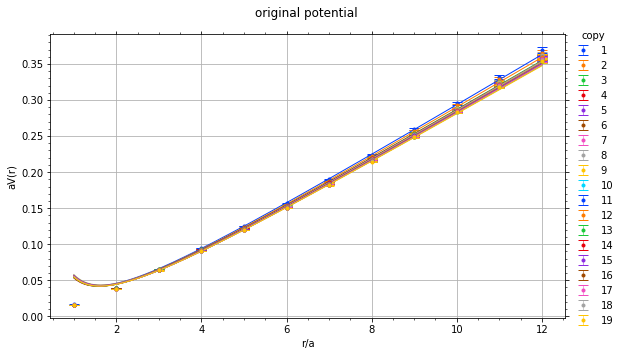

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//copy_comparison


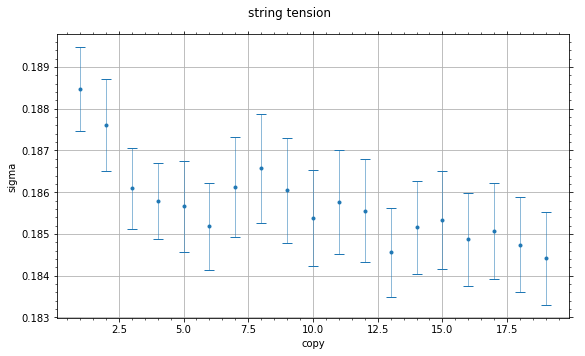

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//string_tension


In [12]:
show_plot = True
coordinate = 'r/a'
hue = 'copy'
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_100/copies=20/0.01/potential_monopole.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (10, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/'
image_name = f'copy_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
plots.plot_potential_single(fit_params, 'copy', 'sigma', 'sigma_err', None, 'copy', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/', 'string_tension', show_plot)

    copy  beta        V0    V0_err     sigma  sigma_err    chi_sq
0      1   6.0 -0.028802  0.002197  0.031213   0.000531  0.002555
1      2   6.0 -0.028072  0.002127  0.030735   0.000516  0.002428
2      3   6.0 -0.027810  0.002098  0.030484   0.000506  0.002311
3      4   6.0 -0.027664  0.002070  0.030386   0.000501  0.002256
4      5   6.0 -0.027263  0.002081  0.030158   0.000504  0.002398
5      6   6.0 -0.027471  0.002142  0.030168   0.000516  0.002537
6      7   6.0 -0.027732  0.002188  0.030233   0.000528  0.002662
7      8   6.0 -0.027694  0.002211  0.030203   0.000534  0.002821
8      9   6.0 -0.027557  0.002188  0.030118   0.000529  0.002711
9     10   6.0 -0.027371  0.002122  0.030046   0.000512  0.002482
10    11   6.0 -0.027420  0.002125  0.030037   0.000511  0.002441
11    12   6.0 -0.027474  0.002140  0.030048   0.000514  0.002511
12    13   6.0 -0.027383  0.002141  0.029989   0.000514  0.002500
13    14   6.0 -0.027632  0.002191  0.030065   0.000526  0.002608
14    15  

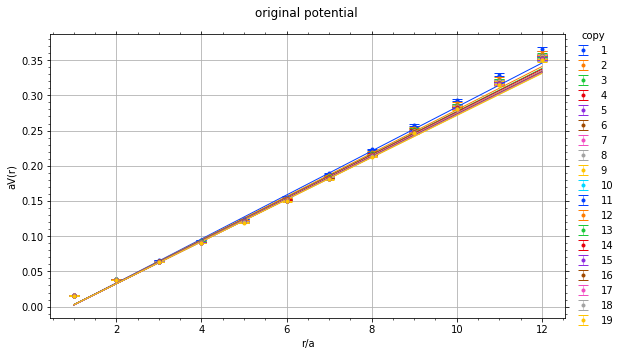

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20//copy_comparison


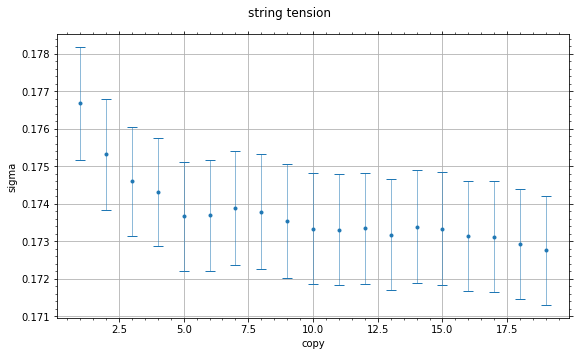

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20//string_tension


In [19]:
show_plot = True
coordinate = 'r/a'
hue = 'copy'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_100/copies=20/0.01/potential_monopole.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (8, 8)}}]
image_path = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20/'
image_name = f'copy_comparison'
data = potential_data.get_potantial_df(paths)
# data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 12)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 12), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
# x_fit = np.linspace(6, 6.4, 1000)
# y_fit = scaler.get_a_sqrt_sigma(x_fit)
# df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
# df_string_tension_fit['fit'] = 'fit'
# fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'copy', 'sigma', 'sigma_err', None, 'copy', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20/', 'string_tension', show_plot)
# plots.plot_potential_single(fit_params, 'beta', 'alpha', 'alpha_err', 'fit', 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/gluodynamics/', 'coulomb_coefficient', show_plot, black_line_y=-math.pi/12)

/home/ilya/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


   copy  Nt potential_type        V0    V0_err     sigma  sigma_err    chi_sq
0     1  16       original -0.003487  0.000730  0.038245   0.000108  0.002891
1     1  18       original -0.005352  0.000523  0.038576   0.000089  0.000776
2     1  20       original -0.011278  0.000584  0.040294   0.000092  0.008274
   copy  Nt potential_type        V0    V0_err     sigma  sigma_err    chi_sq
0     1  16       original -0.003487  0.000730  0.195563   0.000277  0.002891
1     1  18       original -0.005352  0.000523  0.196407   0.000227  0.000776
2     1  20       original -0.011278  0.000584  0.200733   0.000230  0.008274


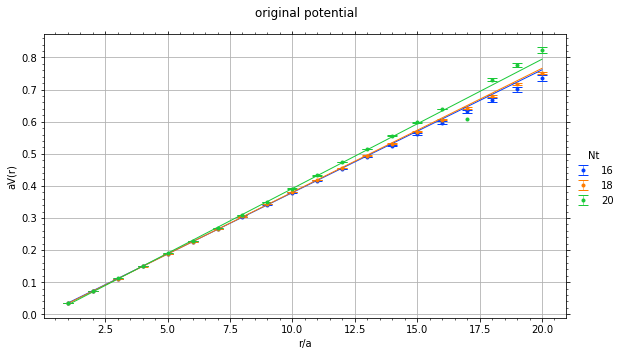

../../images/potential/su3/QCD/140MeV//size_comparison


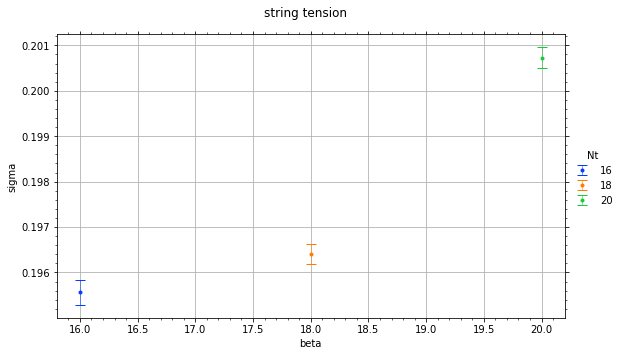

../../images/potential/su3/QCD/140MeV//string_tension_nt20


In [70]:
show_plot = True
coordinate = 'r/a'
hue = 'Nt'
groupby = []
# paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
#           'parameters': {'Nt': 20, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 8), 'smearing_step': (11, 11)}},
#           {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt18/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
#           'parameters': {'Nt': 18, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 8), 'smearing_step': (11, 11)}},
#           {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt16/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
#           'parameters': {'Nt': 16, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 7), 'smearing_step': (11, 11)}},
#           {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt14/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
#           'parameters': {'Nt': 14, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 6), 'smearing_step': (11, 11)}},
#           {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt12/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
#           'parameters': {'Nt': 12, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 5), 'smearing_step': (11, 11)}},
#           {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt10/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
#           'parameters': {'Nt': 10, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 4), 'smearing_step': (11, 11)}}]
paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 20, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 8), 'smearing_step': (6, 6)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt18/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 18, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 8), 'smearing_step': (6, 6)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt16/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 16, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 7), 'smearing_step': (6, 6)}}]
image_path = f'../../images/potential/su3/QCD/140MeV/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (4, 32), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (4, 32), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'Nt', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/QCD/140MeV/', 'string_tension_nt20', show_plot)

   copy  T  Nt potential_type        V0    V0_err     sigma  sigma_err  \
0     1  1   4       original  0.010239  0.000036  0.004021   0.000004   
1     1  2   6       original  0.026956  0.000322  0.002805   0.000036   
2     1  3   8       original  0.046519  0.001296  0.003907   0.000136   
3     1  4  10       original  0.062507  0.003372  0.007765   0.000388   
4     1  5  12       original  0.054342  0.004821  0.016138   0.000683   
5     1  6  14       original  0.025802  0.003406  0.026130   0.000560   
6     1  7  16       original -0.001237  0.000855  0.037014   0.000152   
7     1  8  18       original -0.004111  0.000417  0.037825   0.000077   
8     1  8  20       original -0.006836  0.000392  0.038941   0.000072   

     chi_sq  
0  0.000002  
1  0.000121  
2  0.001128  
3  0.006514  
4  0.017915  
5  0.017752  
6  0.007829  
7  0.003268  
8  0.000461  
   copy  T  Nt potential_type        V0    V0_err     sigma  sigma_err  \
0     1  1   4       original  0.010239  0.00

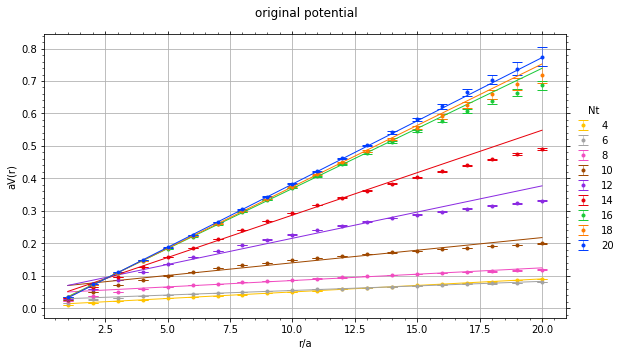

../../images/potential/su3/QCD/140MeV//size_comparison


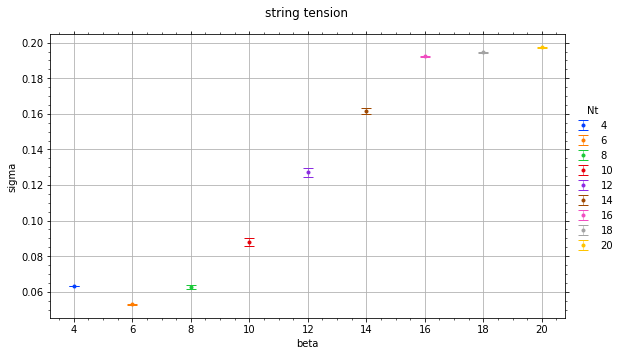

../../images/potential/su3/QCD/140MeV//string_tension_nt20


KeyError: "['alpha', 'alpha_err'] not in index"

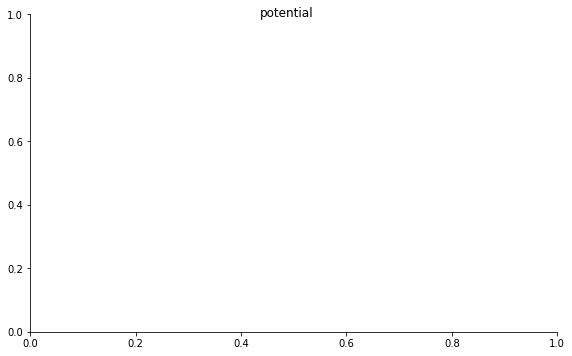

In [61]:
show_plot = True
coordinate = 'r/a'
hue = 'Nt'
groupby = []
paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 20, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (8, 8), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt18/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 18, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (8, 8), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt16/HYP0_APE_alpha=0.6/steps_500/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 16, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (7, 7), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt14/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 14, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (6, 6), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt12/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 12, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (5, 5), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt10/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 10, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (4, 4), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt8/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 8, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (3, 3), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt6/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 6, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 2), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt4/HYP0_APE_alpha=0.6/steps_2000/copies=1/potential_monopole.csv',
          'parameters': {'Nt': 4, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 1), 'smearing_step': (26, 26)}}]
image_path = f'../../images/potential/su3/QCD/140MeV/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
# data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
# data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (4, 32), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (4, 32), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'Nt', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/QCD/140MeV/', 'string_tension_nt20', show_plot)
plots.plot_potential_single(fit_params, 'Nt', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/QCD/140MeV/', 'coulomb_coefficient_nt20', show_plot,  black_line_y=-math.pi/12)

   copy  smearing potential_type        V0    V0_err     alpha  alpha_err  \
0     0         6       original  0.277371  0.001438 -0.417980   0.003061   
1     0        11       original  0.286711  0.001359 -0.433749   0.002969   
2     0        16       original  0.287943  0.001442 -0.435690   0.003240   
3     0        21       original  0.290558  0.001097 -0.440979   0.002517   
4     0        26       original  0.292186  0.001034 -0.444532   0.002382   
5     0        31       original  0.292623  0.001411 -0.445974   0.003241   

      sigma  sigma_err    chi_sq  
0  0.037032   0.000154  0.000715  
1  0.035639   0.000140  0.000306  
2  0.035449   0.000142  0.000285  
3  0.035171   0.000103  0.000146  
4  0.035038   0.000097  0.000059  
5  0.035075   0.000132  0.000642  
   copy  smearing potential_type        V0    V0_err     alpha  alpha_err  \
0     0         6       original  0.277371  0.001438 -0.417980   0.003061   
1     0        11       original  0.286711  0.001359 -0.43374

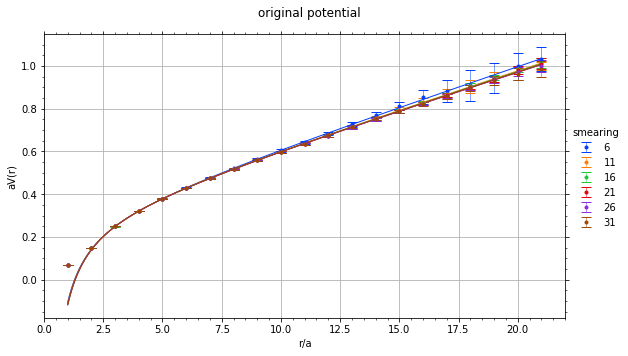

../../images/potential/su3/QCD/140MeV//size_comparison


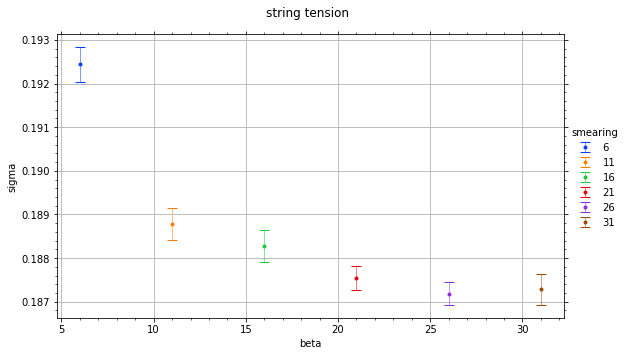

../../images/potential/su3/QCD/140MeV//string_tension_nt20


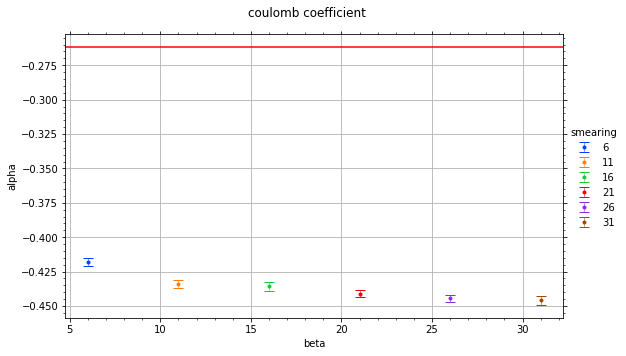

../../images/potential/su3/QCD/140MeV//coulomb_coefficient_nt20


In [53]:
show_plot = True
coordinate = 'r/a'
hue = 'smearing'
groupby = []
paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'smearing': 6, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 21), 'T': (1, 10), 'smearing_step': (6, 6)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'smearing': 11, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 21), 'T': (1, 10), 'smearing_step': (11, 11)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'smearing': 16, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 21), 'T': (1, 10), 'smearing_step': (16, 16)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'smearing': 21, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 21), 'T': (1, 10), 'smearing_step': (21, 21)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'smearing': 26, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 21), 'T': (1, 10), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'smearing': 31, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 21), 'T': (1, 10), 'smearing_step': (31, 31)}}]
image_path = f'../../images/potential/su3/QCD/140MeV/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'smearing', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/QCD/140MeV/', 'string_tension_nt20', show_plot)
plots.plot_potential_single(fit_params, 'smearing', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/QCD/140MeV/', 'coulomb_coefficient_nt20', show_plot,  black_line_y=-math.pi/12)

   copy  T  time potential_type        V0    V0_err     alpha  alpha_err  \
0     0  5     5       original  0.285361  0.001750 -0.450138   0.004837   
1     0  6     6       original  0.305230  0.002734 -0.490970   0.007337   
2     0  7     7       original  0.315613  0.004434 -0.506996   0.011592   
3     0  8     8       original  0.292910  0.006053 -0.449639   0.015349   

      sigma  sigma_err    chi_sq  
0  0.037775   0.000148  0.003567  
1  0.034856   0.000241  0.005824  
2  0.032944   0.000404  0.021811  
3  0.034908   0.000574  0.043379  
   copy  T  time potential_type        V0    V0_err     alpha  alpha_err  \
0     0  5     5       original  0.285361  0.001750 -0.450138   0.004837   
1     0  6     6       original  0.305230  0.002734 -0.490970   0.007337   
2     0  7     7       original  0.315613  0.004434 -0.506996   0.011592   
3     0  8     8       original  0.292910  0.006053 -0.449639   0.015349   

      sigma  sigma_err    chi_sq  
0  0.194359   0.000381  0.00

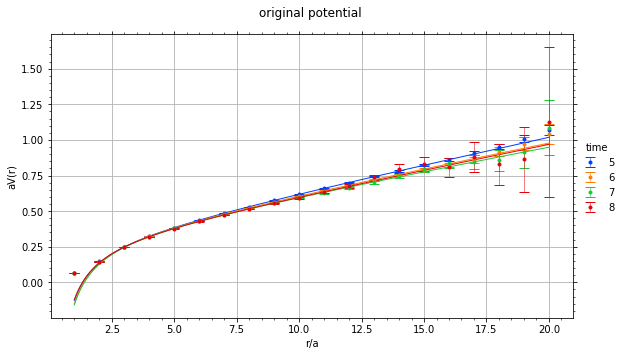

../../images/potential/su3/QCD/140MeV//size_comparison


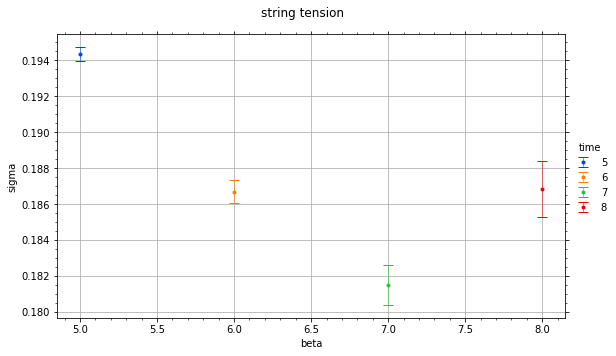

../../images/potential/su3/QCD/140MeV//string_tension_nt20


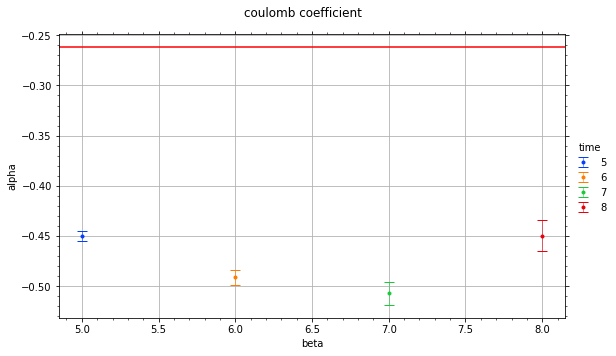

../../images/potential/su3/QCD/140MeV//coulomb_coefficient_nt20


In [54]:
show_plot = True
coordinate = 'r/a'
hue = 'time'
groupby = []
paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'time': 5, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (5, 5), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'time': 6, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (6, 6), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'time': 7, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (7, 7), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'time': 8, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (8, 8), 'smearing_step': (26, 26)}}]
image_path = f'../../images/potential/su3/QCD/140MeV/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
# data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
# data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (4, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (4, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'time', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/QCD/140MeV/', 'string_tension_nt20', show_plot)
plots.plot_potential_single(fit_params, 'time', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/QCD/140MeV/', 'coulomb_coefficient_nt20', show_plot,  black_line_y=-math.pi/12)

   copy  Nt potential_type        V0    V0_err     alpha  alpha_err     sigma  \
0     0  12       original  0.547166  0.020750 -1.002852   0.055938  0.003261   
1     0  14       original  0.434850  0.009469 -0.761046   0.026079  0.017466   
2     0  16       original  0.358537  0.005765 -0.604514   0.016756  0.027750   
3     0  18       original  0.295067  0.003721 -0.449902   0.011066  0.034138   
4     0  20       original  0.297460  0.001246 -0.461920   0.003788  0.034716   

   sigma_err    chi_sq  
0   0.001822  0.062214  
1   0.000807  0.004076  
2   0.000452  0.001150  
3   0.000280  0.001020  
4   0.000090  0.000044  
   copy  Nt potential_type        V0    V0_err     alpha  alpha_err     sigma  \
0     0  12       original  0.547166  0.020750 -1.002852   0.055938  0.057106   
1     0  14       original  0.434850  0.009469 -0.761046   0.026079  0.132159   
2     0  16       original  0.358537  0.005765 -0.604514   0.016756  0.166582   
3     0  18       original  0.295067  0

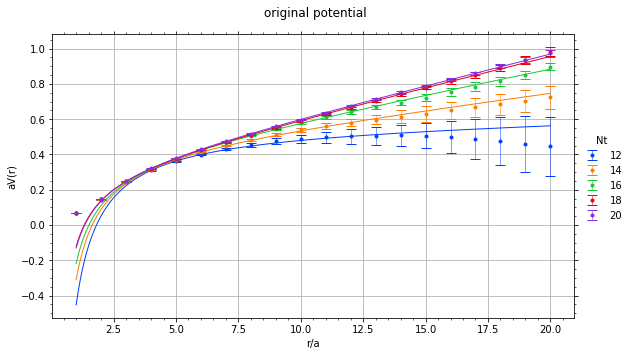

../../images/potential/su3/QCD/140MeV//size_comparison


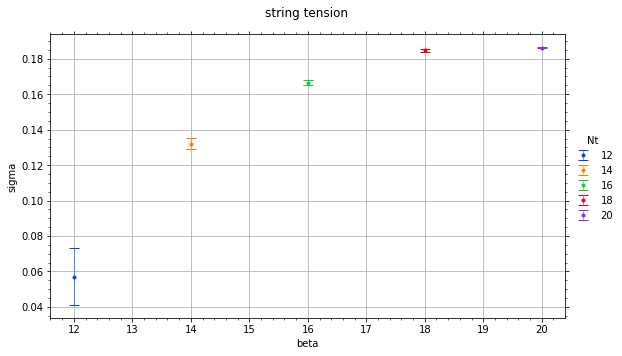

../../images/potential/su3/QCD/140MeV//string_tension_nt20


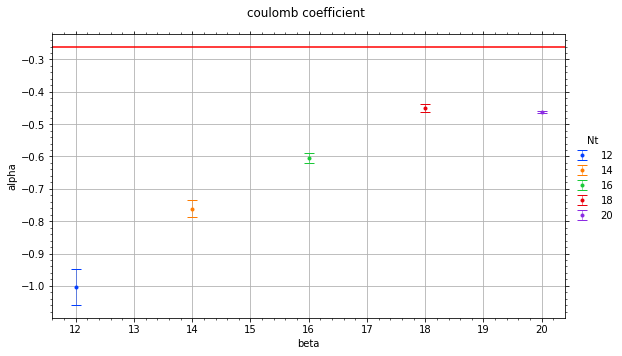

../../images/potential/su3/QCD/140MeV//coulomb_coefficient_nt20


In [57]:
show_plot = True
coordinate = 'r/a'
hue = 'Nt'
groupby = []
paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 20, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 8), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt18/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 18, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 8), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt16/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 16, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 8), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt14/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 14, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 8), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt12/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 12, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 4), 'smearing_step': (26, 26)}}]
image_path = f'../../images/potential/su3/QCD/140MeV/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (4, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (4, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'Nt', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/QCD/140MeV/', 'string_tension_nt20', show_plot)
plots.plot_potential_single(fit_params, 'Nt', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/QCD/140MeV/', 'coulomb_coefficient_nt20', show_plot,  black_line_y=-math.pi/12)

   copy  T  Nt potential_type        V0    V0_err     alpha  alpha_err  \
0     0  1   4       original  0.182028  0.002725 -0.162655   0.008889   
1     0  2   6       original  0.327402  0.003298 -0.413313   0.010720   
2     0  3   8       original  0.429075  0.001338 -0.672341   0.004219   
3     0  4  10       original  0.460284  0.005671 -0.783839   0.017007   
4     0  5  12       original  0.438757  0.007857 -0.760868   0.022244   
5     0  6  14       original  0.398337  0.009719 -0.682564   0.026460   
6     0  6  16       original  0.333807  0.004946 -0.550395   0.013352   
7     0  6  18       original  0.310716  0.003938 -0.497340   0.010568   
8     0  6  20       original  0.305230  0.002734 -0.490970   0.007337   

      sigma  sigma_err    chi_sq  
0  0.020448   0.000178  0.000107  
1  0.009123   0.000216  0.000219  
2  0.006814   0.000093  0.000053  
3  0.009387   0.000425  0.000953  
4  0.015438   0.000643  0.006280  
5  0.021793   0.000839  0.014723  
6  0.030755   

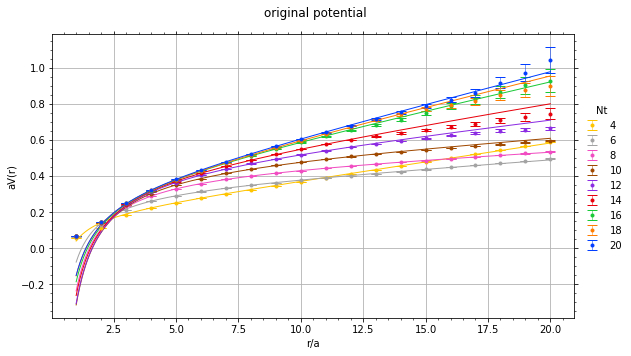

../../images/potential/su3/QCD/140MeV//size_comparison


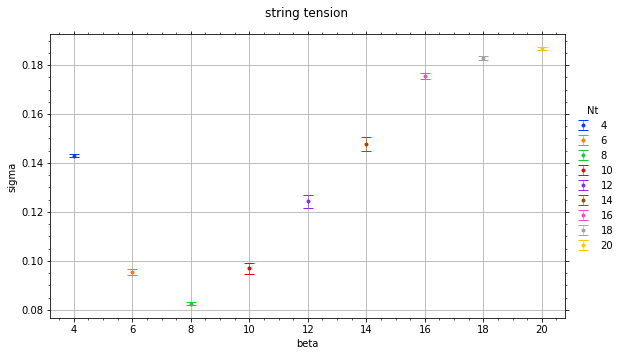

../../images/potential/su3/QCD/140MeV//string_tension_nt20


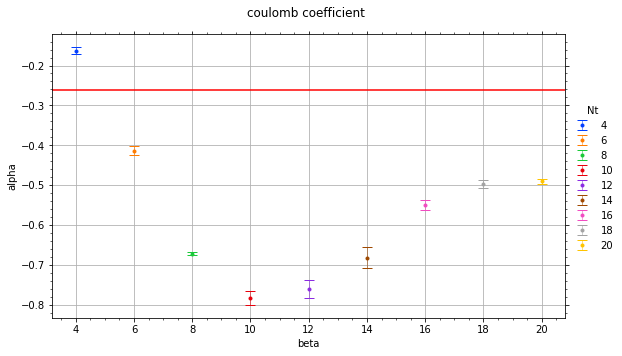

../../images/potential/su3/QCD/140MeV//coulomb_coefficient_nt20


In [55]:
show_plot = True
coordinate = 'r/a'
hue = 'Nt'
groupby = []
paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt20/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 20, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (6, 6), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt18/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 18, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (6, 6), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt16/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 16, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (6, 6), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt14/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 14, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (6, 6), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt12/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 12, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (5, 5), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt10/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 10, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (4, 4), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt8/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 8, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (3, 3), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt6/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 6, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (2, 2), 'smearing_step': (26, 26)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/QCD/140MeV/nt4/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'Nt': 4, 'potential_type': 'original'}, 'constraints': {'r/a': (1, 20), 'T': (1, 1), 'smearing_step': (26, 26)}}]
image_path = f'../../images/potential/su3/QCD/140MeV/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
# data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
# data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (4, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (4, 32), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'Nt', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/QCD/140MeV/', 'string_tension_nt20', show_plot)
plots.plot_potential_single(fit_params, 'Nt', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/QCD/140MeV/', 'coulomb_coefficient_nt20', show_plot,  black_line_y=-math.pi/12)

   copy  T  beta  size        V0    V0_err     alpha  alpha_err     sigma  \
0     0  6   6.0  16^4  0.157441  0.001300 -0.271760   0.002520  0.046645   
1     0  6   6.0  24^4  0.147759  0.007814 -0.258142   0.014623  0.048138   
2     0  6   6.0  32^4  0.146947  0.000768 -0.256103   0.001505  0.048411   

   sigma_err        chi_sq  
0   0.000159  1.631465e-07  
1   0.001002  1.416762e-02  
2   0.000093  1.861801e-05  
   copy  T  beta  size        V0    V0_err     alpha  alpha_err     sigma  \
0     0  6   6.0  16^4  0.157441  0.001300 -0.271760   0.002520  0.215974   
1     0  6   6.0  24^4  0.147759  0.007814 -0.258142   0.014623  0.219405   
2     0  6   6.0  32^4  0.146947  0.000768 -0.256103   0.001505  0.220025   

   sigma_err        chi_sq  
0   0.000367  1.631465e-07  
1   0.002282  1.416762e-02  
2   0.000210  1.861801e-05  


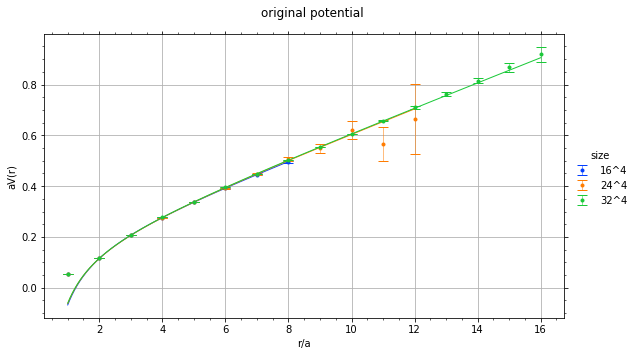

../../images/potential/su3/gluodynamics//size_comparison


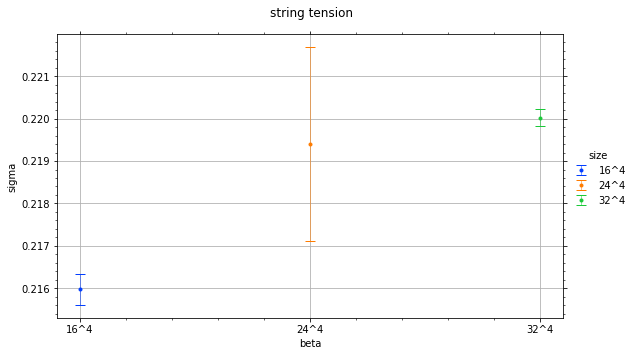

../../images/potential/su3/gluodynamics//string_tension_beta=6p0


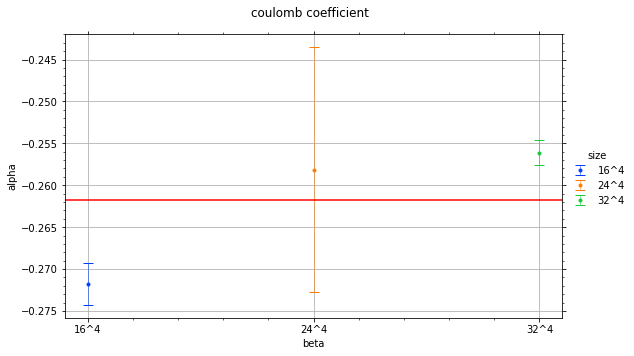

../../images/potential/su3/gluodynamics//coulomb_coefficient_beta=6p0


In [25]:
show_plot = True
coordinate = 'r/a'
hue = 'size'
groupby = []
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0, 'size': '16^4'}, 'constraints': {'r/a': (1, 8), 'T': (6, 6)}},
          {'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.8/smearing/potential_original.csv',
          'parameters': {'beta': 6.0, 'size': '24^4'}, 'constraints': {'r/a': (1, 12), 'T': (6, 6), 'smearing_step': (13, 13)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0, 'size': '32^4'}, 'constraints': {'r/a': (1, 16), 'T': (6, 6)}}]
# paths = [{'path': '../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.8/smearing/potential_original.csv',
#           'parameters': {'beta': 6.0, 'size': '24^4'}, 'constraints': {'r/a': (1, 12), 'T': (6, 6), 'smearing_step': (10, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('smearing_step', axis = 1)
# data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
# data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'size', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/', 'string_tension_beta=6p0', show_plot)
plots.plot_potential_single(fit_params, 'size', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/gluodynamics/', 'coulomb_coefficient_beta=6p0', show_plot,  black_line_y=-math.pi/12)

         beta  size        r/a     aV(r)
0    beta=6.0  24^4   1.000000  0.381979
1    beta=6.0  24^4   1.011011  0.386154
2    beta=6.0  24^4   1.022022  0.390249
3    beta=6.0  24^4   1.033033  0.394268
4    beta=6.0  24^4   1.044044  0.398213
..        ...   ...        ...       ...
995  beta=6.0  24^4  11.955956  1.198519
996  beta=6.0  24^4  11.966967  1.199055
997  beta=6.0  24^4  11.977978  1.199592
998  beta=6.0  24^4  11.988989  1.200129
999  beta=6.0  24^4  12.000000  1.200665

[1000 rows x 4 columns]
       beta  size        V0    V0_err     alpha  alpha_err     sigma  \
0  beta=6.0  24^4  0.679177  0.006382 -0.349226   0.014163  0.045581   

   sigma_err    chi_sq  
0   0.000545  0.000055  
0.2134962778954389


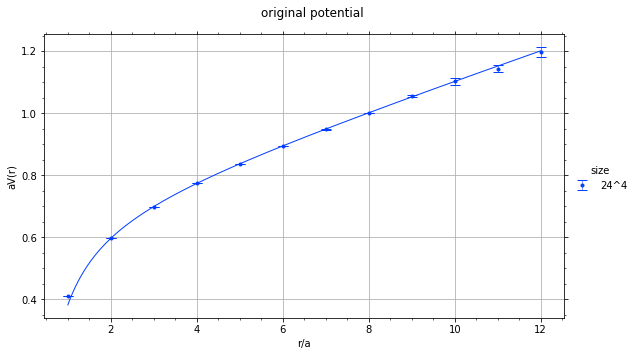

../../images/potential/su3/gluodynamics/beta6.0//size_comparison


In [3]:
show_plot = True
coordinate = 'r/a'
hue = 'size'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.0', 'size': '24^4'}, 'constraints': {'r/a': (1, 12), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/beta6.0/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
print(df_fit)
print(fit_params)
fit_params = fit_params.reset_index()
print(math.sqrt(fit_params.at[0, 'sigma']))
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

   index      beta     size        V0    V0_err     alpha  alpha_err  \
0      0  beta=6.2  32^3x64  0.645419  0.003120 -0.322844   0.007939   
1      0  beta=6.2     32^4  0.638481  0.001475 -0.310809   0.003753   

      sigma  sigma_err    chi_sq  
0  0.024667   0.000216  0.000045  
1  0.025398   0.000102  0.000012  
0.1593676579186971 0.0003197910388366388


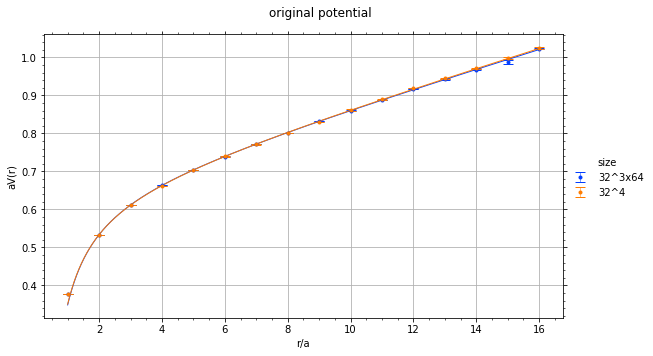

../../images/potential/su3/gluodynamics/beta6.2//size_comparison


In [9]:
show_plot = True
coordinate = 'r/a'
hue = 'size'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^4/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'size': '32^4'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'size': '32^3x64'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/beta6.2/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index()
print(fit_params)
print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

         V0    V0_err     alpha  alpha_err     sigma  sigma_err    chi_sq
0  0.638481  0.001475 -0.310809   0.003753  0.025398   0.000102  0.000012


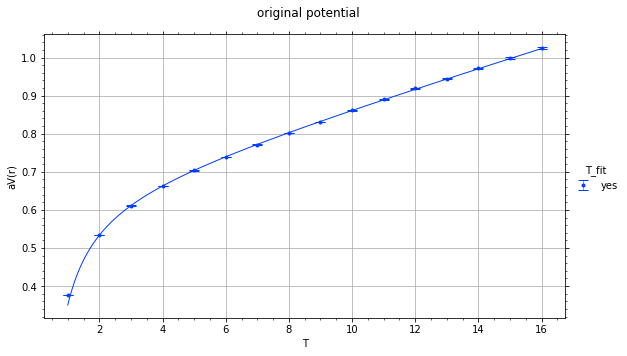

../../images/potential/su3/gluodynamics/32^4/beta6.2//potential_orignal


In [9]:
show_plot = True
coordinate = 'r/a'
hue = 'T_fit'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^4/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'APE'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/32^4/beta6.2/'
image_name = f'potential_orignal'
data = potential_data.get_potantial_df(paths)
data = data.groupby('r/a').apply(fit.potential_fit_T, (2, 8)).reset_index(level='r/a')
data['T_fit'] = 'yes'
data['potential_type'] = 'original'
df_fit = fit.potential_fit_data(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')
df_fit['potential_type'] = 'original'
fit_params = fit.make_fit(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'T', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

         V0   V0_err     alpha  alpha_err     sigma  sigma_err    chi_sq
0  0.645419  0.00312 -0.322844   0.007939  0.024667   0.000216  0.000045


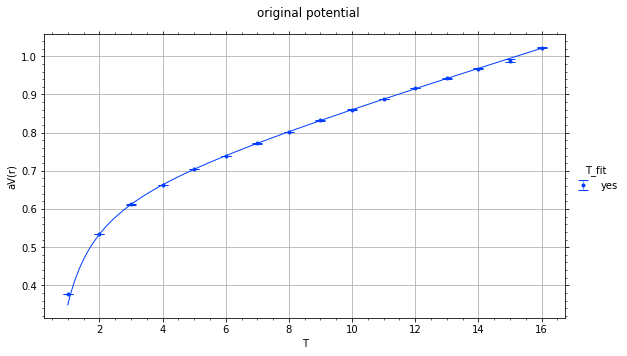

../../images/potential/su3/gluodynamics/32^3/beta6.2//potential_orignal


In [7]:
show_plot = True
coordinate = 'r/a'
hue = 'T_fit'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'APE'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/32^3x64/beta6.2/'
image_name = f'potential_orignal'
data = potential_data.get_potantial_df(paths)
data = data.groupby('r/a').apply(fit.potential_fit_T, (2, 8)).reset_index(level='r/a')
data['T_fit'] = 'yes'
data['potential_type'] = 'original'
df_fit = fit.potential_fit_data(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')
df_fit['potential_type'] = 'original'
fit_params = fit.make_fit(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'T', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

In [10]:
# plot potential T dependence for each r
def plot_T_dependence(paths, image_path, show_plot, fit=None):
    data = potential_data.get_potantial_df(paths)
    data['fit'] = 'T_fit'
    if fit != None:
        df_fits = data.groupby('r/a').apply(fit.potential_fit_data, (2, 8), fit.func_exponent,['C', 'b', 'V'], 'T', 'aV(r)', err_col='err').reset_index(level='r/a')
        df_fits['fit'] = 'T_fit'
    for r in data['r/a'].unique():
        if fit == None:
            fit1 = None
        else:
            fit1 = df_fits[df_fits['r/a'] == r]
        plots.plot_potential_single(data[data['r/a'] == r], 'T', 'aV(r)', 'err', 'fit', 'T', 'aV(r)', 'original potential', image_path, f'potential_T_dependence_r={r}', show_plot, fit1)